In [1]:
!nvidia-smi

Wed Oct  8 17:08:52 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti      Off| 00000000:1A:00.0 Off |                  N/A |
| 18%   42C    P2               52W / 250W|   2041MiB / 11264MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
#hack till I make it a real package..

#hack till I make it a real package..
import os

#using GPU, comment out if on CPU
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
import jax 
#jax.config.update('jax_disable_jit', False)


In [3]:
from jax import Array 
from functools import partial
from typing import List

#from jaxfluids.equation_information import EquationInformation
#from jaxfluids.materials.material_manager import MaterialManager

#EDITED FOR DIFFHYDRO

#need to figure out where cfl goes, probably into flux directly?

class EquationManager:
    """ The EquationManager stores information on the system of equations that is being solved.
    Besides providing indices for the different variables, the EquationManager provides the 
    equation-specific primitive/conservative conversions and the flux calculation.

    NOTE! For DiffHydro it also rolls in the materials properties as an (safe) Ideal Gas. Might go back to 
    materials class if lots of weird fluids emerge...
    """
    def __init__(
            self,
           # material_manager: MaterialManager,
          #  equation_information: EquationInformation
            ) -> None:

       # self.equation_information = equation_information

        self.mass_ids = 0#equation_information.mass_ids 
        self.vel_ids = (1,2,3)#equation_information.velocity_ids 
        self.energy_ids = -1
        self.velocity_minor_axes = ((2, 3), (3, 1), (1, 2))
        self.equation_type = "SINGLE-PHASE"#equation_information.equation_type
        self.gamma = 1.6
        self.thermal_conductivity_model = None
        self.sutherland_parameters = None
        self.eps = 1E-20
        self.cfl = 0.6
        self.mesh_shape = [100,100,100]
        
    def get_conservatives_from_primitives(self, primitives: Array) -> Array:
        """Converts primitive variables to conservative ones.
        Wrapper for 5 equation DIM and single-phase/level-set model.

        :param primitives: _description_
        :type primitives: Array
        :return: _description_
        :rtype: Array
        """
        if self.equation_type == "SINGLE-PHASE":
            rho = primitives[self.mass_ids] # = rho
            e = self.get_specific_energy(primitives[self.energy_ids], rho)
            rhou = rho * primitives[self.vel_ids[0]] # = rho * u
            rhov = rho * primitives[self.vel_ids[1]] # = rho * v
            rhow = rho * primitives[self.vel_ids[2]] # = rho * w
            E = rho * (0.5 * (
                primitives[self.vel_ids[0]] * primitives[self.vel_ids[0]] \
                + primitives[self.vel_ids[1]] * primitives[self.vel_ids[1]] \
                + primitives[self.vel_ids[2]] * primitives[self.vel_ids[2]]) + e)  # E = rho * (1/2 u^2 + e)
            conservatives = jnp.stack([rho, rhou, rhov, rhow, E], axis=0)
        
        else:
            raise NotImplementedError

        return conservatives

    def get_primitives_from_conservatives(self, conservatives: Array) -> Array:
        """Converts conservative variables to primitive variables.

        :param conservatives: Buffer of conservative variables
        :type conservatives: Array
        :return: Buffer of primitive variables
        :rtype: Array
        """           

        if self.equation_type == "SINGLE-PHASE":
            rho = conservatives[self.mass_ids]  # rho = rho
            one_rho = 1.0 / rho
            u = conservatives[self.vel_ids[0]] * one_rho  # u = rho*u / rho
            v = conservatives[self.vel_ids[1]] * one_rho  # v = rho*v / rho
            w = conservatives[self.vel_ids[2]] * one_rho  # w = rho*w / rho
            e = conservatives[self.energy_ids] * one_rho - 0.5 * (u * u + v * v + w * w)
            p = self.get_pressure(e, rho) # p = (gamma-1) * ( E - 1/2 * (rho*u) * u)

            primitives = jnp.stack([rho, u, v, w, p], axis=0)

        else:
            raise NotImplementedError

        return primitives

    def get_fluxes_xi(
            self,
            primitives: Array,
            conservatives: Array,
            axis: int
            ) -> Array:
        """Computes the physical flux in a specified spatial direction.
        Cf. Eq. (3.65) in Toro.

        :param primitives: Buffer of primitive variables
        :type primitives: Array
        :param conservatives: Buffer of conservative variables
        :type conservatives: Array
        :param axis: Spatial direction along which fluxes are calculated
        :type axis: int
        :return: Physical fluxes in axis direction
        :rtype: Array
        """

        if self.equation_type == "SINGLE-PHASE":
            rho_ui = conservatives[axis+1] # (rho u_i)
            rho_ui_u1 = conservatives[axis+1] * primitives[self.vel_ids[0]] # (rho u_i) * u_1
            rho_ui_u2 = conservatives[axis+1] * primitives[self.vel_ids[1]] # (rho u_i) * u_2
            rho_ui_u3 = conservatives[axis+1] * primitives[self.vel_ids[2]] # (rho u_i) * u_3
            ui_Ep = primitives[axis+1] * (conservatives[self.energy_ids] + primitives[self.energy_ids])
            if axis == 0:
                rho_ui_u1 += primitives[self.energy_ids]
            elif axis == 1:
                rho_ui_u2 += primitives[self.energy_ids]
            elif axis == 2:
                rho_ui_u3 += primitives[self.energy_ids]

            flux_xi = jnp.stack([
                rho_ui,
                rho_ui_u1,
                rho_ui_u2,
                rho_ui_u3,
                ui_Ep],
                axis=0)
        
        else:
            raise NotImplementedError

        return flux_xi

    def get_specific_heat_capacity(self, T: Array): #-> Union[float, Array]:
        """Calculates the specific heat coefficient per unit mass.
        [c_p] = J / kg / K

        :param T: _description_
        :type T: Array
        :raises NotImplementedError: _description_
        :return: _description_
        :rtype: Array
        """
        return self.cp

    def get_specific_heat_ratio(self, T: Array): #-> Union[float, Array]:
        """Calculates the specific heat ratio.

        :param T: _description_
        :type T: Array
        :raises NotImplementedError: _description_
        :return: _description_
        :rtype: Array
        """
        return self.gamma

    def get_psi(self, p: Array, rho: Array) -> Array:
        """See base class. """
        return p / rho

    def get_grueneisen(self, rho: Array, T: Array = None) -> Array:
        """See base class. """
        return self.gamma - 1

    def get_speed_of_sound(self, p: Array, rho: Array) -> Array:
        """See base class. """
        return jnp.sqrt( self.gamma * jnp.maximum( p, self.eps) / jnp.maximum( rho, self.eps ) )

    def get_pressure(self, e: Array, rho: Array) -> Array:
        """See base class. """
        return (self.gamma - 1.0) * e * rho

    def get_temperature(self, p: Array, rho: Array) -> Array:
        """See base class. """
        return p / (rho * self.R + self.eps)

    def get_specific_energy(self, p:Array, rho:Array) -> Array:
        """See base class. """
        # Specific internal energy
        return p / (rho * (self.gamma - 1.0))

    def get_total_energy(
            self,
            p:Array,
            rho:Array,
            u:Array,
            v:Array,
            w:Array
            ) -> Array:
        """See base class. """
        # Total energy per unit volume
        # (sensible, i.e., without heat of formation)
        return p / (self.gamma - 1) + 0.5 * rho * ( (u * u + v * v + w * w) )

    def get_total_enthalpy(
            self,
            p:Array,
            rho:Array,
            u:Array,
            v:Array,
            w:Array
            ) -> Array:
        """See base class. """
        # Total specific enthalpy
        # (sensible, i.e., without heat of formation)
        return (self.get_total_energy(p, rho, u, v, w) + p) / rho

    def get_stagnation_temperature(
            self,
            p:Array,
            rho:Array,
            u:Array,
            v:Array,
            w:Array
        ) -> Array:
        T = self.get_temperature(p, rho)
        cp = self.get_specific_heat_capacity(T)
        return T + 0.5 * (u * u + v * v + w * w) / cp


    
    def _set_transport_properties(self,func) -> None:

        if self.thermal_conductivity_model is not None:
            if self.thermal_conductivity_model == "CUSTOM":
                self.thermal_conductivity_fun = func

            elif self.thermal_conductivity_model == "SUTHERLAND":
                sutherland_parameters = self.sutherland_parameters
                self.kappa_ref = sutherland_parameters[0]
                self.T_ref_kappa = sutherland_parameters[1]
                self.C_kappa = sutherland_parameters[2]
            else:
                raise
        else:
            raise
    
    def get_thermal_conductivity(
            self,
            temperature: Array,
            primitives: Array,
            density: Array = None,
            partial_densities: Array = None,
            volume_fractions: Array = None,
        ) -> Array:
        """Computes the thermal conductivity

        :param T: _description_
        :type T: Array
        :raises NotImplementedError: _description_
        :return: _description_
        :rtype: Array
        """
        if self.thermal_conductivity_model == "CUSTOM":
            thermal_conductivity = self.thermal_conductivity_fun(T)

        elif self.thermal_conductivity_model == "SUTHERLAND":
            thermal_conductivity = \
                self.kappa_ref * ((self.T_ref_kappa + self.C_kappa)/(T + self.C_kappa)) \
                * (T/self.T_ref_kappa)**1.5
        elif self.thermal_conductivity_model == "ELBADRY":
            ALPHA= 813.142554365 
            # 1e-20/(1.4mH)^2 erg*s^{-1}*cm^3 in simulation unit
            # (cooling, Sutherland & Dopita 1993)
            BETA =406571277.182611837
            #1e-20/(1.4mH)^2 erg*s^{-1}*cm^3 in simulation unit
            #heating, Kim & Ostriker 2015)
            GAMMA= 406.571277183
            # 1.4mH/cm^3 in simulation unit
            #(hydrogen number density, Kim & Ostriker 2015)
            DELTA=0.03459841649374997
            # 1.2/(1.4mH)*1e2 cm^3 in simulation unit
            #(electron number density, El-Badry 2019)
            EPSILON=3468.366826027353
            # erg*s^{-1}*cm^{-1} in simulation unit
            #thermal conductivity, El-Badry 2019)
            ZETA=5.111496271545331E-12
            #hydrogen mass over Boltzmann constant in simulation unit
            MHKB=115.98518596699539

            temp = temperature/1E7
            n_e2 = EPSILON * primitives[self.mass_ids]
            kappa_hot = (1.7e11 * temp_7**2.5) / (1 + 0.029 * jnp.log10(temp_7 / jnp.sqrt(n_e2)))
                # thermal conductivity for neutral atomic collisions (Parker 1953)
            temp_4 = temperature/ 1.0E4
            kappa_cool = 2.5E5 * jnp.sqrt(temp_4)
                    #adjast for Athena++ units
            kappa = jnp.where(T>6.6E4, kappa_hot, kappa_cool)
            kappa = kappa * 1.4 * MHKB / primitives[self.mass_ids]
            kc = 1.8E12 / DELTA * 1.4 * MHKB

            kappa_max = 1E16
            
            thermal_conductivity = jnp.minimum(kc*jnp.ones(temp.shape), 1.0 / (1.0 / kappa + 1.0 / kappa_max))
            
        else:
            raise NotImplementedError

        return thermal_conductivity

In [4]:
import LaxFriedrichs
import HLLC
import recon
import jax.numpy as jnp

In [5]:
class ConductiveFlux:
    def __init__(self,
                EquationManager,
                 Solver,
                 Recon,
                 positivity = False
                ):
        self.eq_manage = EquationManager
        self.solver = Solver
        self.recon = Recon
        
        self.positivity = positivity
        self.positivity_stencil = recon.WENO1()
        self.dx_o = 1
        
        try: #3d
            self.flux_shapes = (5,eq.mesh_shape[0],eq.mesh_shape[1],eq.mesh_shape[2])
        except: #2d, z velocity axis usually just constant...
            self.flux_shapes = (5,eq.mesh_shape[0],eq.mesh_shape[1])

        
    def flux(self,sol,ax,params):
        primitives = self.eq_manage.get_primitives_from_conservatives(sol)
        
        primitives_xi_L = self.recon.reconstruct_xi(
            primitives,
            axis=ax,
            j=0)
        
        primitives_xi_R = self.recon.reconstruct_xi(
            primitives,
            axis=ax,
            j=1)


        conservative_xi_L = self.eq_manage.get_conservatives_from_primitives(primitives_xi_L)
        conservative_xi_R = self.eq_manage.get_conservatives_from_primitives(primitives_xi_R)

        if self.positivity:
            conservative_xi_L, primitives_xi_L, count_L = self.compute_positivity_preserving_interpolation(
                primitives=primitives,
                primitives_xi_j=primitives_xi_L,
                j=0,
                axis=ax)
            conservative_xi_R, primitives_xi_R, count_R = self.compute_positivity_preserving_interpolation(
                primitives=primitives,
                primitives_xi_j=primitives_xi_R,
                j=1,
                axis=ax)
        #final axis is from vel-id, so one off... should standardize at some point!
        flux,_,_ = self.solver.solve_riemann_problem_xi(primitives_xi_L,primitives_xi_R,conservative_xi_L,conservative_xi_R,ax-1)
        return flux
    

    def timestep(self,sol):
        print(sol)
        v = jnp.abs(sol[1:-1]/sol[0])
    
        temp_quant = (self.eq_manage.gamma-1)*(sol[-1]-sol[0]*jnp.sum(v**2.0,axis=0)/2.0)
        P = jnp.maximum(jnp.where(temp_quant>0,temp_quant,0),0.0)
    
        cs = jnp.sqrt(self.eq_manage.gamma*P/sol[0])
    
        #cmax = jnp.nanmax(jnp.nanmax(v)+cs)
        cmax = jnp.max(jnp.max(v)+cs)
        dt = self.eq_manage.cfl*self.dx_o/cmax
        return dt
    
    def compute_positivity_preserving_interpolation(self,
            primitives: Array,
            primitives_xi_j: Array,
            j: int,
            axis: int):
        
        cell_state_xi_safe_j = self.positivity_stencil.reconstruct_xi(
            primitives, axis, j)

        rho_j = primitives_xi_j[self.eq_manage.mass_ids]
        
        mask = jnp.where(rho_j < self.eq_manage.eps, 0, 1)
        counter = jnp.sum(1 - mask)    # TODO check in parallel

        primitives_xi_j = primitives_xi_j * mask + cell_state_xi_safe_j * (1 - mask)

        # CHECK ENERGY / PRESSURE
        p_j = primitives_xi_j[self.eq_manage.energy_ids]
        
        # OPTION 1 - CHECK PRESSURE DIRECTLY
        mask = jnp.where(p_j < self.eq_manage.eps, 0, 1)

        # OPTION 2 - CHECK VIA INTERNAL ENERGY
        # rhoe_j = rho_j * self.material_manager.get_specific_energy(p_j, rho=rho_j)
        # mask_j = jnp.where(rhoe_j - pb < self.eps.pressure, 0, 1)

        counter += jnp.sum(1 - mask)    # TODO check in parallel
        primitives_xi_j = primitives_xi_j * mask + cell_state_xi_safe_j * (1 - mask)

        conservative_xi_j = self.eq_manage.get_conservatives_from_primitives(primitives_xi_j)

        return conservative_xi_j,primitives_xi_j,counter

In [30]:
from jax import jit
import signal_speeds



class NoBoundary:
    def impose(sol,ax):
        return sol #no boundary restrictuon

class NoForcing:
    def timestep(x):
        return 1E10
    def force(i,sol,params):
        return sol #no froce

@jax.tree_util.register_pytree_node_class
class hydro:
    #TO DO, pretty up this area...
    def __init__(self,
                 n_super_step = 600,
                 max_dt = 0.5, 
                 boundary = NoBoundary,
                 snapshots = False,
                splitting_schemes=[[3,1,2,2,1,3],[1,2,3,3,2,1],[2,3,1,1,3,2]], #cyclic permutations
                fluxes = None, #convection, conduction
                forces = [NoForcing], #gravity, etc.
                maxjit=False):
        #parameters that are held constant per run (i.e. probably don't want to take derivatives with respect to...)
   #     self.init_dt = init_dt # tiny starting timestep to smooth out anything too sharp
        self.splitting_schemes = splitting_schemes #strang splitting for x,y,z sweeps
        self.max_dt = max_dt
        self.boundary = boundary
        #supersteps, each superstep has len(splitting_schemes) time steps
        self.n_super_step = n_super_step
        self.snapshots = snapshots #poorly names/
        self.outputs = []
        self.fluxes = fluxes
        self.forces = forces
        self.maxjit = maxjit
        self.dx_o = 1.0
        self.timescale = jnp.zeros(self.n_super_step)

    
    def timestep(self,fields):
        dt = []
        for flux in self.fluxes:
            dt.append(flux.timestep(fields))
        for force in self.forces:
            dt.append(force.timestep(fields))
        print(dt)
        return jnp.min(jnp.array(dt))
    
    def flux(self,sol,ax,params):
        total_flux = jnp.zeros(sol.shape)
        for flux in self.fluxes:
            total_flux += flux.flux(sol,ax,params)
        return total_flux
    
    def forcing(self,i,sol,params): #all axis independant? 
        total_force = jnp.zeros(sol.shape)
        for force in self.forces:
            total_force += force.force(i,sol,params)
        return total_force
    
    def solve_step(self,sol,dt,ax,params):
        ##RK2 method
        
        fu1 = self.flux(sol,ax,params) 
        #first order upwind
        rhs_cons = (fu1 - jnp.roll(fu1, 1, axis=ax)) 
        
        u1 = sol - rhs_cons * dt / (2.0 * self.dx_o)
        #second order step

        fu = self.flux(sol,ax,params)  
            
        rhs_cons = (fu - jnp.roll(fu, 1, axis=ax))  #fu or fu1?
        
        sol = sol - (rhs_cons) * dt / self.dx_o
        return sol
    
    @jax.checkpoint
    def sweep_stack(self,state,dt,i):
        sol,params = state
        for scheme in self.splitting_schemes:
            for nn,ax in enumerate(scheme):
                sol = self.boundary.impose(sol,ax)
                sol = self.solve_step(sol,dt/len(scheme)*2,int(ax),params)                 
                # experimental
                sol = sol.at[0].set(jnp.abs(sol[0])) #experimental...
                sol = sol.at[-1].set(jnp.abs(sol[-1])) #experimental...
    
        return sol
    
   # @jax.jit
    def evolve(self,input_fields,params):
        self.outputs=[]
        #main loop
        state = (input_fields,params)

        #need to rework the UI to get out snapshots from jitted function, hack for now...
        if self.maxjit:
            state  = jax.lax.fori_loop(0, self.n_super_step, self.hydrostep_adapt, state)
        else:
            for i in range(0,self.n_super_step):
                state = self.hydrostep_adapt(i,state)
                if self.snapshots:
                    if i%self.snapshots==0: #comment out most times...
                        self.outputs.append(state)
        return state
        
    @partial(jit, static_argnums=0)
    def hydrostep_adapt(self,i,state):
        fields,params = state
        print("f",fields)
        ttt = self.timestep(fields)
        ttt = jnp.minimum(self.max_dt,ttt)
        dt = (ttt)
        return self._hydrostep(i,state,dt)
    
    @jax.jit
    def _hydrostep(self,i,state,dt):
        fields,params = state

        #save actual timescale used, mostly important if you are using hydro_adapt
#        self.timescale[i].set(dt)
        
        hydro_output = self.sweep_stack(state,dt,i)
        
        fields = hydro_output

        fields = self.forcing(i,fields,params)
            
        return (fields,params)
    
    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children, **aux_data)

    def tree_flatten(self):
        #this method is needed for JAX control flow
        children = ()  # arrays / dynamic values
        aux_data = {
                    "boundary":self.boundary,
                    "snapshots":self.snapshots,
                   "splitting_schemes":self.splitting_schemes,
                    "fluxes":self.fluxes,"forces":self.forces,"maxjit":self.maxjit}  # static values
        return (children, aux_data)

In [31]:
eq = EquationManager()
ss = signal_speeds.signal_speed_Rusanov
solver = HLLC.HLLC(equation_manager=eq,signal_speed=ss)

In [32]:
cf = ConductiveFlux(eq,solver,recon.MUSCL3(limiter="SUPERBEE"))

In [33]:
hydrosim = hydro(fluxes=[cf],maxjit=True)#,splitting_schemes = [[1,2,2,1],[2,1,1,2]])

'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)


In [34]:
import jax.numpy as jnp
def sedov_2d(E0,rho):
        #doesn't really work yet for non-square boxes...
        dV = (100)**2
        hc = int(100/2)-1
        sol = jnp.zeros((5,100,100,100))
        sol = sol.at[0].set(rho)
        sol = sol.at[-1].set(1.0E-3)
        sol = sol.at[4,hc,hc,hc].set(E0/dV)
        rmax = 3.0*(100/2.0)/4.0
        tf = jnp.sqrt((rmax/1.15)**5/E0)
        return sol, tf

In [35]:
U,_ = sedov_2d(1E7,0.1)

In [36]:
U.shape

(5, 100, 100, 100)

In [37]:
params = {}
q = hydrosim.evolve(U,params)

f Traced<ShapedArray(float32[5,100,100,100])>with<DynamicJaxprTrace(level=2/0)>
Traced<ShapedArray(float32[5,100,100,100])>with<DynamicJaxprTrace(level=2/0)>
[Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>, 10000000000.0]


'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)
'+ptx89' is not a recognized feature for this target (ignoring feature)


In [38]:
q[0].shape

(5, 100, 100, 100)

Populating the interactive namespace from numpy and matplotlib


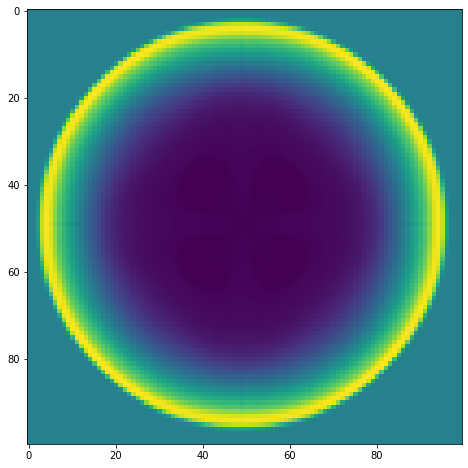

In [39]:
%pylab inline
plt.figure(figsize=(8,8))

imshow(q[0][0][:,50,:])

In [40]:
def isotropy_score(rho, xlen, ylen, nbins=36):
    nx, ny = rho.shape
    dx, dy = xlen/nx, ylen/ny
    x = (np.arange(nx) + 0.5) * dx
    y = (np.arange(ny) + 0.5) * dy
    X, Y = np.meshgrid(x, y, indexing="xy")
    Xc, Yc = X - 0.5*xlen, Y - 0.5*ylen
    r = np.sqrt(Xc**2 + Yc**2)
    theta = (np.arctan2(Yc, Xc) + 2*np.pi) % (2*np.pi)

    rho_np = np.asarray(rho)
    rho0 = np.median(rho_np)
    mask = rho_np >= 1.5 * rho0
    if not np.any(mask):
        return np.inf

    # angular bins: take 95th percentile radius per bin where mask is true
    edges = np.linspace(0, 2*np.pi, nbins+1)
    radii = []
    for i in range(nbins):
        sel = (theta >= edges[i]) & (theta < edges[i+1]) & mask
        if np.any(sel):
            radii.append(np.percentile(r[sel], 95))
    if len(radii) < 3:
        return np.inf
    radii = np.array(radii)
    return float(np.std(radii) / (np.mean(radii) + 1e-12))

In [46]:
isotropy_score(np.roll(q[0][0][:,50,:],0),100,100)

0.011022184450465617